### SARIMA MODELLING AND FORECASTING

<p>We have been provided monthly sales data from a well known Australian retail chain. The data ranges from April 1982 to December 2014. Management has asked us to estimate Sales for the next five years, or specifically, the next 60 steps.<p>
<p>To perform this task, we will identify the appropriate SARIMAX model and fit it to our data. We will then use the model to make our forecast.<p/>
<p>We tackle this problem using the Box-Jenkins method, taking raw data and using it for production purposes.</p>
<li>Identification - determining if the time series is appropriate in it's current form, or if it requires transforming due to non-stationarity
<li>Estimation - determining the most appropriate AR and MA coefficients for the model, fitting them and measuring thier accuracy
<li>Model Diagnostics - running diagnostics on the performance of our model; are the residuals normal and uncorrelated?

In [36]:
#Import the necessary Python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]

### Identification

<p>We start by importing our Sales Data, saves as RetailData. We will import this from a csv file to a Pandas Dataframe that can be used for manipulation, EDA, model fitting and finally for forecasting.<p/>
<p>After importing the time series data and visualising the unaltered obsevations, we can see see that the data is non-statiuonary in its current form. 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 393 entries, 1982-04-01 to 2014-12-01
Data columns (total 1 columns):
Turnover    393 non-null float64
dtypes: float64(1)
memory usage: 6.1 KB
None
            Turnover
Month               
1982-04-01      15.6
1982-05-01      15.8
1982-06-01      15.2
1982-07-01      15.2
1982-08-01      14.5
            Turnover
Month               
2014-08-01      69.8
2014-09-01      85.3
2014-10-01      73.9
2014-11-01      94.2
2014-12-01     154.9


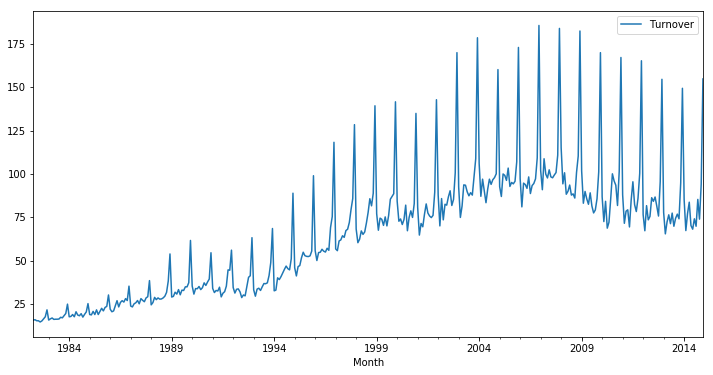

In [46]:
#Importing our Sales Data from a csv file into a Pandas Dataframe.
df = pd.read_csv('RetailData.csv', index_col='Student.ID', header=0, usecols=['Student.ID','26026813'], skiprows=[1,2,3,4])
df.columns=['Turnover']
df.index.names = ['Month']
df.index = pd.to_datetime(df.index, format = '%b-%y')

print(df.info())
print(df.head())
print(df.tail())
df.plot()
plt.show()

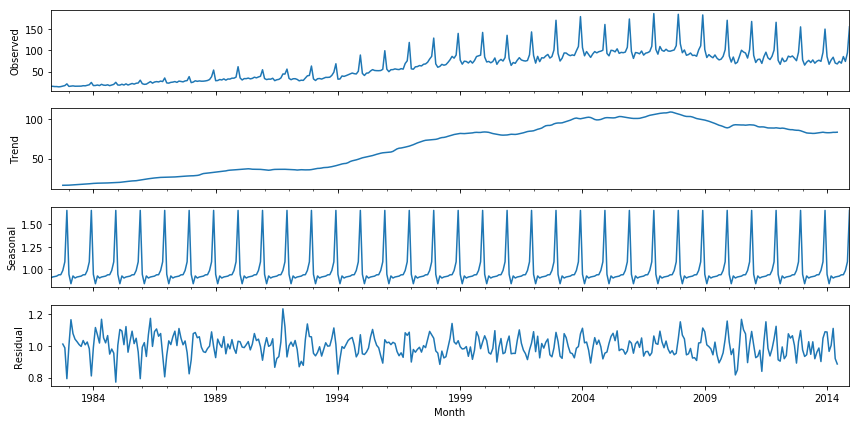

In [39]:
#Perform seasonal decomposition of our time series, 
#allowing us to visualise the trend component, seasonal component and the residual component.
from statsmodels.tsa.seasonal import seasonal_decompose
m_decomp_results = seasonal_decompose(df, freq=12, model='multiplicative')

m_decomp_results.plot()
plt.show()

<p>At a glance, this time series does not appear to be stationary. A stationary time series will satisfy three criteria;<p/> 
<li>Zero trend; there is a clear upwards trend for the majority of the series,
<li>Constant variance; the increasing seasonal component violates this, as well as the non stationary noise that can be seen between the seasonal peaks,
<li>Constant autocorrelation; this can be investigated further using the Autocorrelation and Partial-autocorrelation functions.
<p>
<p>We will perform an Augmented Dickey Fuller test on this series and comment on the results.<p/>

            Turnover
Month               
1983-05-01 -0.006508
1983-06-01  0.038715
1983-07-01  0.006192
1983-08-01  0.107045
1983-09-01 -0.058142


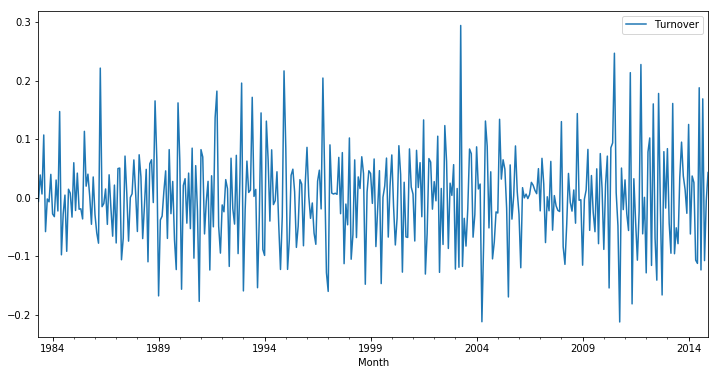

In [40]:
#Taking the first difference of our time series to attempt to create a stationary series
df_log = np.log(df)
df_diff = df_log.diff().diff(12).dropna()
print(df_diff.head())
df_diff.plot()

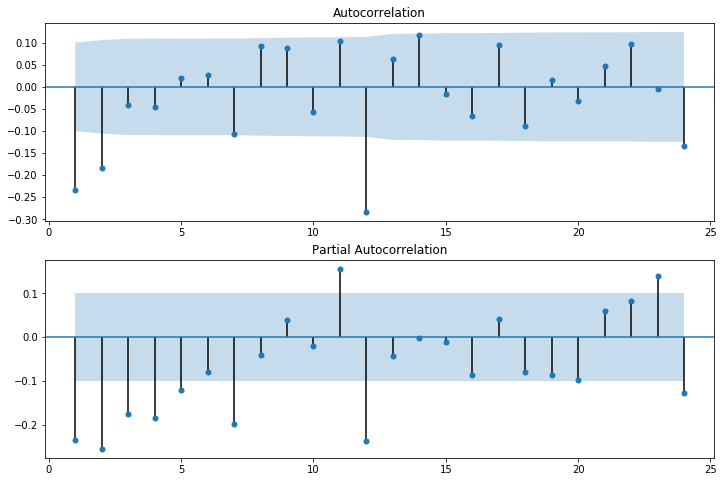

In [41]:
#Plotting ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(df_diff, lags=24, zero=False, ax=ax1)
plot_pacf(df_diff, lags=24, zero=False, ax=ax2)
plt.show()

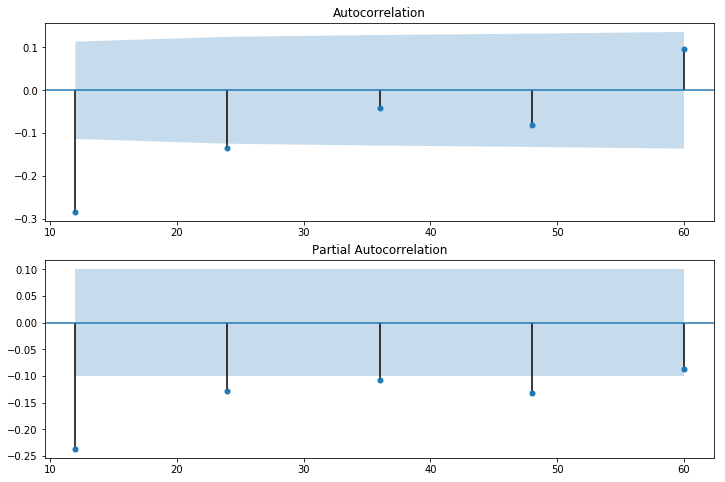

In [42]:
#ACF and PACF of the yearly lags
lags = [12, 24, 36, 48, 60]
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,8))
plot_acf(df_diff, lags=[12,24,36,48,60], zero=False, ax=ax1)
plot_pacf(df_diff, lags=[12,24,36,48,60], zero=False, ax=ax2)
plt.show()

<p> The ACF shows us that the seasonal cycle happens every 12 periods; there is a spike at lag 12 which indicates this. Knowing this, we can perform decomposition by setting freq = 12, which specifies the seasonal length<p/>
<p> The ACF and PACF will also give us an idea of what our SARIMA model's initial paramters AR(p) and MA(q) will be set to;<p/>
<li>The ACF will cut off after p lags, and the PACF will cut off after q lags.
<li>If the ACF tails off, then p may be set to 0. If the PACF tails off, then q may be set to 0.
<p>With this in mind, we will begin with an initial SARIMA of (2,1,2)(4,1,2)12

### Estimation
<p>We can begin the estimation phase

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                           Turnover   No. Observations:                  393
Model:             SARIMAX(2, 1, 2)x(4, 1, 2, 12)   Log Likelihood               -1150.585
Date:                            Sun, 18 Jul 2021   AIC                           2323.171
Time:                                    15:57:08   BIC                           2366.513
Sample:                                04-01-1982   HQIC                          2340.369
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8017      0.431      1.861      0.063      -0.043       1.646
ar.L2         -0.2730      0.161   

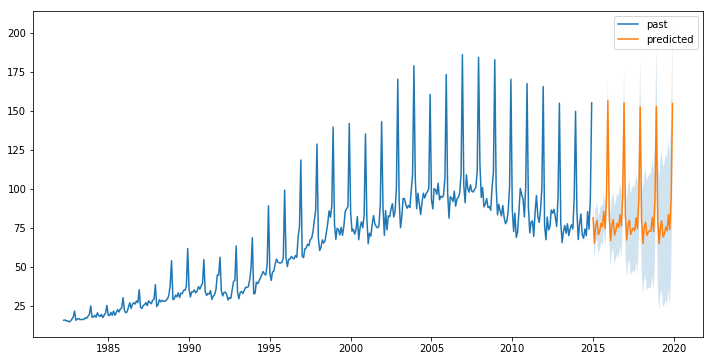

In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df, order=(2,1,2), seasonal_order=(4,1,2,12))
results = model.fit()

forecast_object = results.get_forecast(steps=60)
mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()
dates = mean.index
print(results.summary())

plt.figure()
plt.plot(df.index.values, df.values, label='past')
plt.plot(dates, mean, label='predicted')
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2)
plt.legend()
plt.show()

### Conclusion
<p>Although there are Python packages that can automatically identify and fit an apopropriate SARIMAX model to our data that can then be used for forecasting, this notebook gives a basic rundown of how this process would be done manually.<p/>
<p>As you can see from the above, the SARIMA(2,1,2)(4,1,2) model gave us a time series forecast that also predicted the clear seasonality we observed. Although the estimates become less reliable the further into the future we predict (as seen by the increasing error interval).